In [15]:
import pandas as pd

df = pd.read_csv("data/raw_data/calories.csv")

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [17]:
df.drop(columns=["User_ID"], inplace=True)

In [18]:
def check_if_there_is_empty_cell(dataframe):
    rows_with_empty_cell = dataframe.isnull().any(axis=1).sum()
    dataframe.dropna(inplace=True)
    print(f"Deleted empty cells: {rows_with_empty_cell}")

check_if_there_is_empty_cell(df)

Deleted empty cells: 0


In [19]:
def check_if_there_are_the_same_cell(dataframe, target_column):

    full_duplicates_count = dataframe.duplicated().sum()
    dataframe.drop_duplicates(inplace=True)
    print(f"Deleted {full_duplicates_count} exact duplicate rows (including '{target_column}').")

    feature_cols = [col for col in dataframe.columns if col != target_column]

    partial_duplicate_mask = dataframe.duplicated(subset=feature_cols, keep=False)
    partial_duplicates_count = partial_duplicate_mask.sum()
    dataframe.drop(index=dataframe[partial_duplicate_mask].index, inplace=True)
    print(f"Deleted {partial_duplicates_count} partial duplicates (same features, different '{target_column}').")

check_if_there_are_the_same_cell(df, target_column='Calories')

Deleted 1 exact duplicate rows (including 'Calories').
Deleted 0 partial duplicates (same features, different 'Calories').


In [20]:
print(df['Gender'].value_counts())

Gender
female    7552
male      7447
Name: count, dtype: int64


In [21]:
df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2

In [22]:
import numpy as np

def detect_outliers_iqr(df, target_column='Calories', factor=1.5):
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    numerical_columns = [col for col in numerical_columns if col != target_column]

    outliers_summary = {}

    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        percent = len(outliers) / len(df) * 100
        outliers_summary[col] = {
            'count': len(outliers),
            'percent': round(percent, 2),
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

    return outliers_summary

outlier_stats = detect_outliers_iqr(df)
for col, stats in outlier_stats.items():
    print(f"{col}: {stats['count']} outliers ({stats['percent']}%)")


Age: 0 outliers (0.0%)
Height: 14 outliers (0.09%)
Weight: 6 outliers (0.04%)
Duration: 0 outliers (0.0%)
Heart_Rate: 1 outliers (0.01%)
Body_Temp: 369 outliers (2.46%)
BMI: 14 outliers (0.09%)


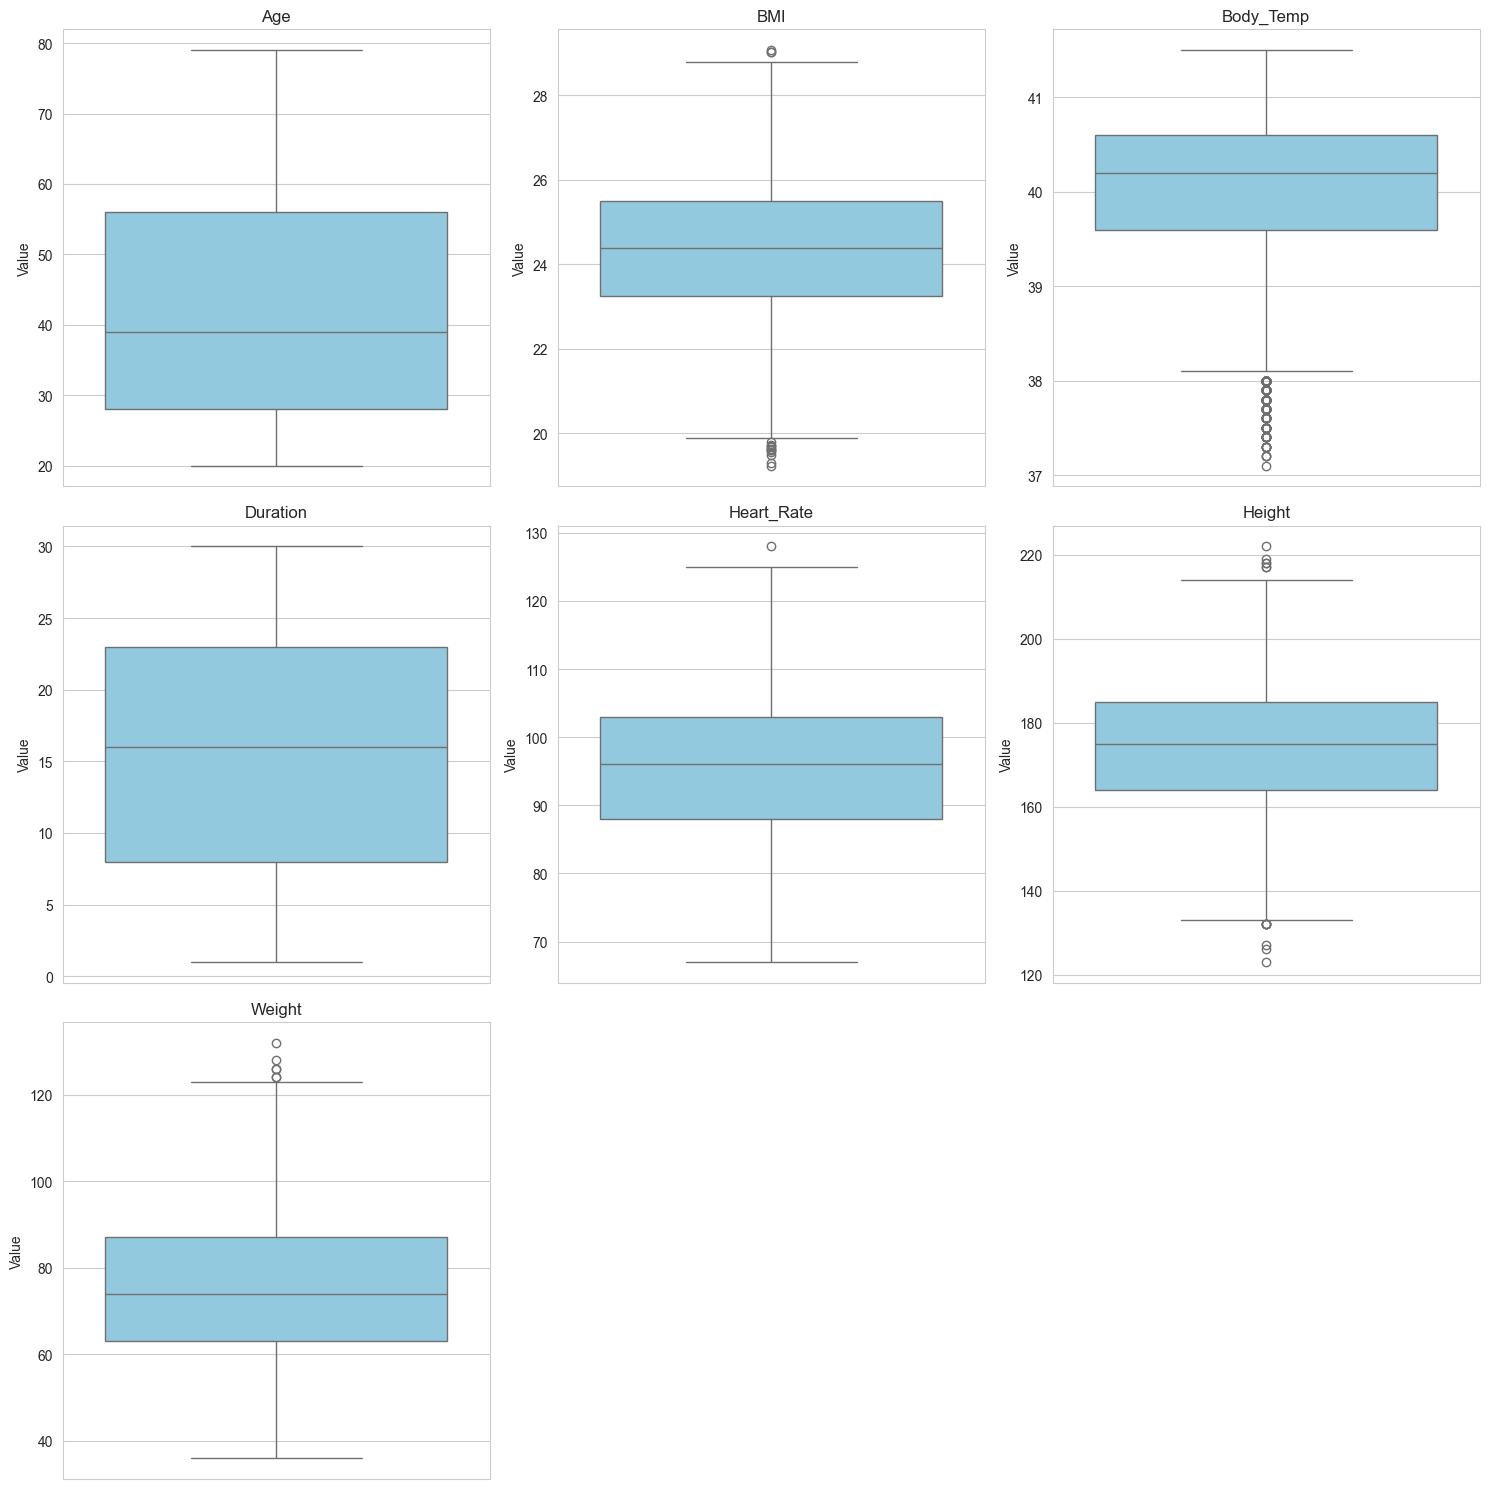

In [23]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

numerical_columns = df.select_dtypes(include=[np.number]).columns
numerical_columns = numerical_columns.difference(['Calories'])
n = len(numerical_columns)

ncols = 3
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Value')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [24]:
correlations = df.corr(numeric_only=True)['Calories'].drop('Calories').sort_values(key=abs, ascending=False)
print(correlations.round(3))

Duration      0.955
Heart_Rate    0.898
Body_Temp     0.825
Age           0.154
BMI           0.056
Weight        0.035
Height        0.017
Name: Calories, dtype: float64


In [25]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns='Calories')
y = df['Calories']

le = LabelEncoder()
X_enc = X.copy()
for col in X_enc.select_dtypes(include='object'):
    X_enc[col] = LabelEncoder().fit_transform(X_enc[col])

mi = mutual_info_regression(X_enc, y, random_state=42)
mi_series = pd.Series(mi, index=X_enc.columns).sort_values(ascending=False)

print(mi_series.round(4))

Duration      1.5098
Body_Temp     0.9846
Heart_Rate    0.8743
Age           0.0235
Weight        0.0192
Height        0.0061
Gender        0.0038
BMI           0.0000
dtype: float64


In [26]:
df = df[['Duration', 'Body_Temp', 'Heart_Rate', 'Age', 'Gender', 'Calories']]

In [27]:
df.to_csv("data/preprocessed_data/preprocessed_calories.csv", index=False)